# tira_mfa_exploration
Get distribution data from MFA alignments.
In theory, we should be able to spot deviant transcriptions through introspection of FA output,
e.g. missing words in the transcription will result in weirdly long word alignments and vice versa.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

import os
os.chdir(r'C:\projects\malachor5')
import sys
sys.path.append(r'C:\projects\malachor5\scripts')
from kws import textgrid_to_df

Aggregate all aligned TextGrids into a single DataFrame

In [2]:
align_dir = r'C:\projects\malachor5\data\dataset_clips\tira-asr\mfa_output\himidan'
tg_paths = glob(os.path.join(align_dir, '*.TextGrid'))
df_list = []
for tg_path in tqdm(tg_paths):
    tg_df = textgrid_to_df(tg_path, words_only=False)
    tg_df['filename']=tg_path
    df_list.append(tg_df)
df=pd.concat(df_list)
print(len(df))
df.head()

100%|██████████| 23204/23204 [00:28<00:00, 824.74it/s]


504854


,start,end,text,speaker,tier,filename
0,0.00,0.05,,words,words,C:\projects\malachor5\data\dataset_clips\tira-...
1,0.05,0.67,ɛ̀vɛ̀,words,words,C:\projects\malachor5\data\dataset_clips\tira-...
2,0.67,0.76,,words,words,C:\projects\malachor5\data\dataset_clips\tira-...
3,0.00,0.05,,phones,phones,C:\projects\malachor5\data\dataset_clips\tira-...
4,0.05,0.09,ɛ,phones,phones,C:\projects\malachor5\data\dataset_clips\tira-...


In [11]:
df['index']=df['filename'].apply(os.path.basename).str.replace('.TextGrid', '').astype(int)
df=df.set_index('index')
df['duration']=df['end']-df['start']
df.head()

,start,end,text,speaker,tier,filename,duration
index,,,,,,,
0,0.00,0.05,,words,words,C:\projects\malachor5\data\dataset_clips\tira-...,0.05
0,0.05,0.67,ɛ̀vɛ̀,words,words,C:\projects\malachor5\data\dataset_clips\tira-...,0.62
0,0.67,0.76,,words,words,C:\projects\malachor5\data\dataset_clips\tira-...,0.09
0,0.00,0.05,,phones,phones,C:\projects\malachor5\data\dataset_clips\tira-...,0.05
0,0.05,0.09,ɛ,phones,phones,C:\projects\malachor5\data\dataset_clips\tira-...,0.04


# Check transcriptions
Compare transcription stored in textgrid with `.lab` file in case MFA changed anything.

In [37]:
def get_transcription_for_tg(df, idx, words_mask=None):
    if words_mask is None:
        words_mask = df['tier']=='words'
    word_df = df[words_mask].loc[idx]
    if type(word_df) is pd.Series:
        return word_df['text']
    word_df = word_df.sort_values('start')
    words = ' '.join(word_df['text'].tolist())
    # remove double whitespace
    words = ' '.join(words.split())
    return words

get_transcription_for_tg(df, 1)

'ɛ̀vɛ̀ jìcə̀lò'

In [ ]:
input_dir = r'C:\projects\malachor5\data\dataset_clips\tira-asr\mfa_input\himidan'
lab_paths = glob(os.path.join(input_dir, '*.lab'))

label_rows = []
words_mask = df['tier']=='words'

for lab_file in tqdm(lab_paths):
    idx = int(os.path.basename(lab_file).removesuffix('.lab'))
    with open(lab_file, encoding='utf8') as f:
        label = f.read().strip()
    if idx not in df.index:
        continue
    mfa_label = get_transcription_for_tg(df, idx, words_mask=words_mask)
    label_rows.append({
        'label': label,
        'mfa_label': mfa_label,
        'index': idx,
        'filepath': lab_file,
    })
lab_df = pd.DataFrame(label_rows)


  4%|▍         | 966/23261 [00:25<09:54, 37.52it/s]


KeyError: 13563

Get average/median/min/max/std of word/phone length for each training record and save to a separate DataFrame:

In [27]:
ds_record_rows = []
phone_mask = df['tier']=='phones'
word_mask = df['tier']=='words'
nonempty_mask = df['text']!=''
words_df=df[word_mask&nonempty_mask]
phones_df=df[phone_mask&nonempty_mask]
for index in tqdm(df.index.unique()):
    words_for_index = words_df.loc[index]
    phones_for_index =  phones_df.loc[index]
    ds_record_rows.append({
        "index": index,
        "wordlen_max": words_for_index['duration'].max(),
        "wordlen_min": words_for_index['duration'].min(),
        "wordlen_med": np.median(words_for_index['duration']),
        "wordlen_avg": words_for_index['duration'].mean(),
        "wordlen_std": words_for_index['duration'].std(),

        "phonelen_max": phones_for_index['duration'].max(),
        "phonelen_min": phones_for_index['duration'].min(),
        "phonelen_med": np.median(phones_for_index['duration']),
        "phonelen_avg": phones_for_index['duration'].mean(),
        "phonelen_std": phones_for_index['duration'].std(),
    })
record_df = pd.DataFrame(ds_record_rows)

100%|██████████| 23204/23204 [00:37<00:00, 617.91it/s]


<Axes: >

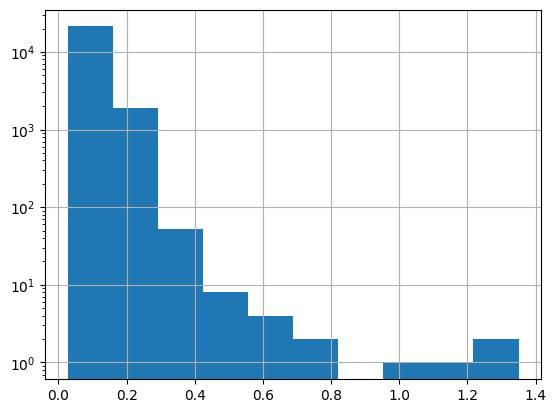

In [38]:
plt.yscale('log')
record_df['phonelen_avg'].hist()


In [31]:
(record_df['wordlen_std']<0.5).sum()/len(record_df)

np.float64(0.9655662816755731)

In [34]:
(record_df['phonelen_std']<0.25).sum()/len(record_df)


np.float64(0.986295466298914)

In [ ]:
align_metadata_csv = r'C:\projects\malachor5\data\dataset_clips\tira-asr\mfa_output\alignment_metadata.csv'
record_df.to_csv(align_metadata_csv)